In [32]:
import torch
import cupy as cp
import cupyx as cpx
import psutil
import numpy as np

## Hardware Setup and Reporting

In [7]:
!nvidia-smi

Tue Jul 23 13:13:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.41                 Driver Version: 552.41         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   36C    P8             12W /  450W |    1107MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
def gpu_setup():
    # Setup for PyTorch:
    if torch.cuda.is_available():
        torch_device = torch.device('cuda')
        print('PyTorch is using GPU {}'.format(torch.cuda.current_device()))
    else:
        torch_device = torch.device('cpu')
        print('GPU unavailable; using CPU')

    # Setup for CuPy:
    cupy_device = cp.cuda.Device(0)
    cupy_device.use()
    print('CuPy is using GPU {}'.format(cupy_device))

    return torch_device, cupy_device

In [8]:
torch_device, cupy_device = gpu_setup()

NameError: name 'gpu_setup' is not defined

In [10]:
BYTES_IN_GB = 1024 * 1024 * 1024
def sys_report():
    print("CPU: ", psutil.cpu_percent(), "percent")
    print("MEM: ", psutil.virtual_memory().available / BYTES_IN_GB, "GB available")
    print("SWAP: ", psutil.swap_memory().used / BYTES_IN_GB, "GB used")
    print("DISK: ", psutil.disk_usage('/').free / BYTES_IN_GB, "GB available")
    print("PyTorch GPU: ", torch.cuda.memory_allocated() / BYTES_IN_GB, "GB used")

In [11]:
sys_report()

CPU:  0.9 percent
MEM:  23.234119415283203 GB available
SWAP:  0.21138381958007812 GB used
DISK:  1606.5283470153809 GB available
PyTorch GPU:  0.0 GB used


## Full-CUDA Hamiltonian Construction

In [12]:
from cupyx.scipy.sparse import identity, kron
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import eigsh 

In [13]:
identity(5, format='csr').toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [14]:
from functools import reduce

In [15]:
import time

In [16]:
import scipy as sp

In [17]:
def tfim_hamiltonian_cuda(N, h, J, periodic, dtype, return_time):
    # TODO: CUDA stores matrices in row-major order--though I'm not yet certain about 
    # how important this is to performance

    start = time.time()

    constants_dtype = cp.float32
    I = identity(2, format='csr', dtype=constants_dtype)
    X = csr_matrix(cp.array([[0.0, 1.0], [1.0, 0.0]]), dtype=constants_dtype)
    Z = csr_matrix(cp.array([[1.0, 0.0], [0.0, -1.0]]), dtype=constants_dtype)

    operators_first_term = np.array([I] * N)
    operators_first_term[0] = Z
    operators_first_term[1] = Z

    operators_second_term = np.array([I] * N)
    operators_second_term[0] = X

    H = csr_matrix((2**N, 2**N), dtype=dtype)

    # NOTE: roll might cause reallocations but is not an issue because 
    # both N and the sizes of I, X, and Z are quite small. TODO: perhaps 
    # verify this and consider a different method?

    for _ in range(N if periodic else N - 1):
        H -= J * reduce(kron, operators_first_term)
        operators_first_term = np.roll(operators_first_term, 1)

    for _ in range(N):
        H -= h * reduce(kron, operators_second_term)
        operators_second_term = np.roll(operators_second_term, 1)

    end = time.time()

    if return_time:
        return H, end - start
    else:   
        return H

In [18]:
from cupyx.profiler import benchmark

In [30]:
print(benchmark(tfim_hamiltonian_cuda, (18, 100, 1, True, cp.float32, False), n_repeat=30, n_warmup=10))

NameError: name 'cp' is not defined

In [19]:
import time

import matplotlib.pyplot as plt

# Define the range of system sizes
system_sizes = range(10, 23)

# Initialize empty lists to store the timings
construction_times = []
total_times = []
bytes = []
mempool_used = []   
pinned_mempool_used = []

mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()

# Loop over the system sizes
for N in system_sizes:
    # Start timing the construction of the Hamiltonian
    start_construction = time.time()

    # Construct the Hamiltonian
    H = tfim_hamiltonian_cuda(N, 100, 1, periodic=True, dtype=cp.float32, return_time=False)

    # End timing the construction of the Hamiltonian
    end_construction = time.time()

    print("Hamiltonian of shape", H.shape, "constructed")

    H_bytes = H.data.nbytes + H.indptr.nbytes + H.indices.nbytes


    # Start timing the total time (including construction and diagonalization)
    start_total = time.time()

    # Diagonalize the Hamiltonian (replace this with your own code)
    # ...

    # End timing the total time
    end_total = time.time()

    # Calculate the construction time and total time
    construction_time = end_construction - start_construction
    total_time = end_total - start_total

    # Append the timings to the lists
    construction_times.append(construction_time)
    total_times.append(total_time)
    bytes.append(H_bytes)
    mempool_used.append(mempool.used_bytes())
    # pinned_mempool_used.append(pinned_mempool.used_bytes())

    # mempool.free_all_blocks()
    # pinned_mempool.free_all_blocks()


Hamiltonian of shape (1024, 1024) constructed
Hamiltonian of shape (2048, 2048) constructed
Hamiltonian of shape (4096, 4096) constructed
Hamiltonian of shape (8192, 8192) constructed
Hamiltonian of shape (16384, 16384) constructed
Hamiltonian of shape (32768, 32768) constructed
Hamiltonian of shape (65536, 65536) constructed
Hamiltonian of shape (131072, 131072) constructed
Hamiltonian of shape (262144, 262144) constructed
Hamiltonian of shape (524288, 524288) constructed
Hamiltonian of shape (1048576, 1048576) constructed
Hamiltonian of shape (2097152, 2097152) constructed
Hamiltonian of shape (4194304, 4194304) constructed


In [20]:
def plot_times(system_sizes, construction_times, label="Construction Time"):
    plt.plot(system_sizes, construction_times, label='Construction Time')
    plt.plot(system_sizes, total_times, label='Total Time')
    plt.xlabel('System Size')
    plt.ylabel('Time (s)')
    plt.title('Hamiltonian Construction and Total Time vs System Size')
    plt.legend()
    plt.show()

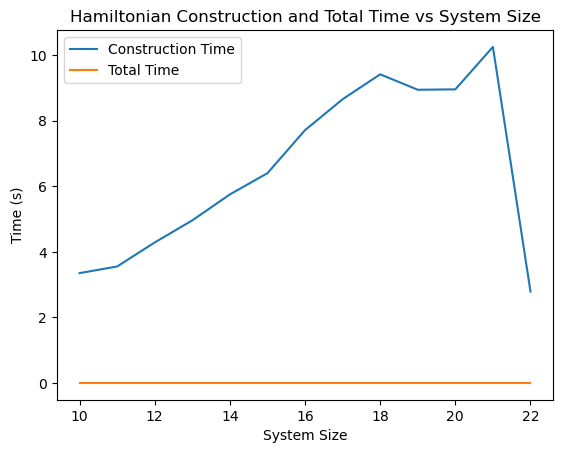

In [21]:
plot_times(system_sizes, construction_times)

In [35]:
with cpx.profiler.profile():
    tfim_hamiltonian_cuda(22, 100, 1, True, cp.float32, False)

In [23]:
tfim_hamiltonian_cuda(18, 100, 1, True, cp.float32, False)

In [29]:
tfim_hamiltonian_cuda(20, 200, 1, True, cp.float32, False)

In [ ]:
def plot_usage(system_sizes, bytes, mempool_used):
  plt.plot(system_sizes, bytes, label='Bytes')
  plt.plot(system_sizes, mempool_used, label='Mempool Used')
  plt.xlabel('System Size')
  plt.ylabel('Memory (bytes)')
  plt.title('Bytes and Mempool Used vs System Size')
  plt.legend()
  plt.show()

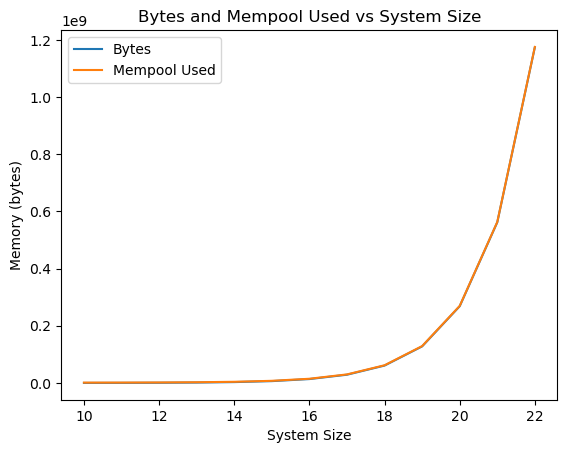

In [ ]:
plot_usage(system_sizes, bytes, mempool_used)

In [ ]:
N = 10

I = identity(2, format='csr', dtype=cp.float64)
X = csr_matrix(cp.array([[0.0, 1.0], [1.0, 0.0]]), dtype=cp.float64)
Z = csr_matrix(cp.array([[1.0, 0.0], [0.0, -1.0]]), dtype=cp.float64)

operators_first_term = np.array([I] * N)
operators_first_term[0] = Z
operators_first_term[1] = Z

In [ ]:
operators_first_term

array([<cupyx.scipy.sparse._csr.csr_matrix object at 0x0000029A6A409A00>,
      dtype=object)